## <b>AdaIN Style Transfer Tutorial</b>

* 원본 논문: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization (ICCV 2017)](https://arxiv.org/abs/1703.06868)
* <b>Feed-Forward Network</b>를 이용하여 <b>임의의(arbitrary)</b> 스타일 이미지를 활용한 <b>스타일 전송(style transfer)</b>을 실시간으로 수행합니다.
    * 이미지에 대한 기울기(gradient)를 직접 구하지 않아도 되므로 <b>훨씬 빠르게</b> 스타일을 전송할 수 있습니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 본 코드는 논문에서 제시한 파라미터 및 설정을 온전히 따르고 있습니다.

#### <b>AdaIN Style Transfer 네트워크</b>

* 앞서 정의한 인코더와 디코더를 이용하는 하나의 네트워크를 정의합니다.
* 먼저 인코더(encoder)를 통해 feature map을 추출한 뒤에 AdaIN을 거쳐 Style Transfer를 수행합니다.
* 디코더는 처리된 feature를 입력받아 결과 이미지를 생성합니다.
* <b>본 실습에서 사용하지는 않지만</b> 아키텍처를 이해하기 위해 코드를 확인해 봅시다.

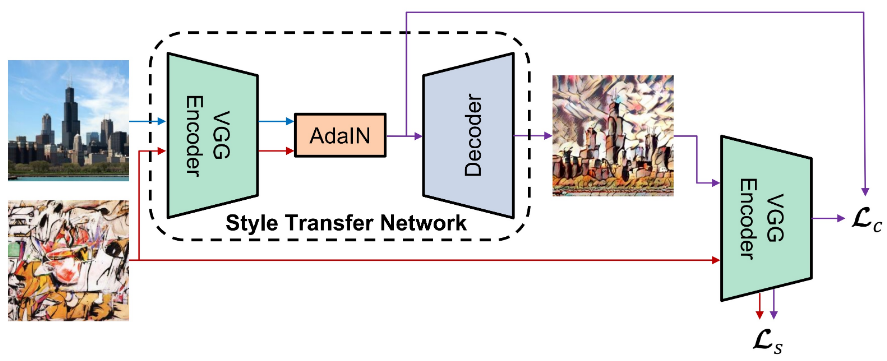

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

# for file path
import natsort
import platform
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow # cv2_imshow(img)
import torchvision.transforms as transforms

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
    * 따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.

In [3]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
* 인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.

In [4]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### <b>사전 학습된(Pre-trained) 모델 불러오기</b> 

In [5]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-08-23 09:09:00--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPV92UExwUlZtMlVn [following]
--2021-08-23 09:09:01--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19

In [6]:
# get trained model
decoder.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

In [7]:
def calc_mean_std(feat, eps=1e-5):
    ''' 이미지의 각 채널 평균(mean)과 표준편차(std) 값을 계산 '''
    size = feat.size()
    assert (len(size) == 4) # Feature Map의 형태: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
    N, C = size[:2]  # 한 번에 하나의 이미지만 넣을 것이므로 N은 1
    feat_var = feat.view(N, C, -1).var(dim=2) + eps # 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

In [8]:
def adaptive_instance_normalization(content_feat, style_feat):
    ''' content image에 style 적용'''
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

In [9]:
def style_transfer(vgg, decoder, content, style, alpha=1.0): # main
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [10]:
def test_transform(size=512): # main
    ''' 이미지 전처리 '''
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
content_tf = test_transform()
style_tf = test_transform()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


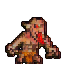

True

In [11]:
import time
start = time.time()

# 디렉터리 내 이미지 전체에 스타일 변이 코드 추가 필요

# main
content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/goblin_64x64/sprite_00.png"
style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror18.jpg"


# 콘텐츠 이미지의 배경 요소 제거 및 선택
content_image = Image.open(str(content_location)).convert("RGB")
content = content_tf(content_image)
content = content.to(device).unsqueeze(0)

# 스타일 이미지 선택
style = style_tf(Image.open(str(style_location)))
style = style.to(device).unsqueeze(0)


with torch.no_grad():
    img_transformed = style_transfer(vgg, decoder, content, style, alpha=0.6) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
img_transformed = img_transformed.cpu()

# 원본 이미지의 크기 저장
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# torch의 shape 순서를 바꿔줌
img_transformed = img_transformed[0].permute(1, 2, 0)

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = img_transformed.shape
x, y = shape[0], shape[1]
origin_image_resized = cv.resize(origin_image, dsize=(y,x))

# alpha channel 추가
final = img_transformed.numpy()
final = cv.cvtColor(np.float32(img_transformed), cv.COLOR_RGB2RGBA)
final[:, :, 3] = origin_image_resized[:,:,3]

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

# float to int 클리핑
final = (final * 255).astype(np.uint)

# plt 기준의 bgr을 cv 기준의 rgb로 변경
b, g, r, a = cv.split(final)
final = cv.merge([r,g,b,a])

#저장
cv2_imshow(final)
cv.imwrite("/content/a.png", final)

In [12]:
# 경로 설정 명세서
platform_path = platform.platform()

IsColab = "bionic" in platform_path
if IsColab:
  style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/*"
  content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/*"
  styled_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Styled_Images/"
else:
  style_location = 'Style_Images/*'
  content_location = "Content_Images/*"
  styled_location = "Styled_Images/"

# 해당 폴더 내에 존재하는 모든 폴더 리스트 불러오기
style_folder_list = glob.glob(style_location)
style_images_list = glob.glob(style_folder_list[0] + "/*")

# Style_location
# Style_Images/TEXTURE/*.jpg or png

# style_images_list, style_image 활용
# style_image = style_images_list[index]

# Content_location
  # Content_Images/ASSET_NAME/*.png
content_folder_list = glob.glob(content_location) # Content_Images/ASSET_NAME

# content_images_list, content_image 활용
# content_images_list = glob.glob(content_folder_list[index] + "/*")
# content_image = style_images_list[index]

# Styled_location
  # Styled_Images/ASSET_NAME/*.png
# asset_name = os.path.split(content_folder_list[index])

# 폴더 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

# 구글 코랩에서 장시간 사용하기
### F12 개발자 모드 후 Console에 입력


```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

```javascript
function CleanCurrentOutput(){ 
    var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='현재 실행 중...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
    if(btn) { console.log("30분마다 출력 지우기");
     btn.click(); 
    } 
} 
setInterval(CleanCurrentOutput,1000*60*30);
```

In [13]:
## main code
import time
start = time.time()

# ★사용 모델명★
model_name = "AdaIN"

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc
  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    print(SI_value)
    style = style_tf(Image.open(str(SI_value)))
    style = style.to(device).unsqueeze(0)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):
        location = CI_value

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_model = styled_location + model_name
        save_folder_style = save_folder_model + "/" + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:
          # 콘텐츠 이미지의 배경 요소 제거 및 선택
          content_image = Image.open(str(location)).convert("RGB")
          content = content_tf(content_image)
          content = content.to(device).unsqueeze(0)

          with torch.no_grad():
            img_transformed = style_transfer(vgg, decoder, content, style, alpha=0.6) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
          img_transformed = img_transformed.cpu()

          # 원본 이미지의 크기 저장
          origin_image = cv.imread(location, cv.IMREAD_UNCHANGED)
          origin_image_shape = origin_image.shape

          # torch 이미지의 shape 순서를 바꿔줌
          img_transformed = img_transformed[0].permute(1, 2, 0)

          # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
          shape = img_transformed.shape
          x, y = shape[0], shape[1]
          origin_image_resized = cv.resize(origin_image, dsize=(y,x))

          # alpha channel 추가
          final = cv.cvtColor(np.float32(img_transformed), cv.COLOR_RGB2RGBA)
          final[:, :, 3] = origin_image_resized[:,:,3]

          # final image 사이즈를 original image 사이즈로 변환
          x, y = origin_image_shape[0], origin_image_shape[1]
          final = cv.resize(final, dsize=(y,x))

          # float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
          final = (final * 255).astype(np.uint)

          # plt 기준의 bgr을 cv 기준의 rgb로 변경
          b, g, r, a = cv.split(final)
          final = cv.merge([r,g,b,a])

          # 저장
          cv.imwrite(save_path, final)

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror38.jpg
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror41.jpg
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror42.jpg
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/dark/horror1.jpg
전체 소요 시간: 10113.0


In [ ]:
def model_auto(style_folder_list, content_folder_list):
  for SF_index, SF_value in enumerate(style_folder_list):
    style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
    style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc
    style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
    for SI_index, SI_value in enumerate(style_images_list):
      style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
      # 스타일 이미지 선택
      print(SI_value)
      style = style_tf(Image.open(str(SI_value)))
      style = style.to(device).unsqueeze(0)

      # 콘텐트 폴더 리스트
      for CF_index, CF_value in enumerate(content_folder_list):

        #콘텐트 이미지 리스트
        content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
        content_images_list = natsort.natsorted(content_images_list)

        # 스타일 전이
        for CI_index, CI_value in enumerate(content_images_list):
          location = CI_value

          # 저장 경로 생성
          asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
          asset_name = os.path.split(CI_value)

          save_folder_model = styled_location + model_name
          save_folder_style = save_folder_model + "/" + style_folder_name[1]
          save_folder_style_index = save_folder_style + "/" + style_image_name[1]
          save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
          createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
          createFolder(save_folder_style) # horror, ice, dark
          createFolder(save_folder_style_index) # horror1, horror2, horror3
          createFolder(save_folder_style_index_content) # goblin, zombie, male

          save_path = save_folder_style_index_content + "/"
          save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

          # 이미 있는 파일이면 건너뛰기
          if os.path.exists(save_path):
            continue
          else:
            # 콘텐츠 이미지의 배경 요소 제거 및 선택
            content_image = Image.open(str(location)).convert("RGB")
            content = content_tf(content_image)
            content = content.to(device).unsqueeze(0)

            with torch.no_grad():
              img_transformed = style_transfer(vgg, decoder, content, style, alpha=0.6) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
            img_transformed = img_transformed.cpu()

            # 원본 이미지의 크기 저장
            origin_image = cv.imread(location, cv.IMREAD_UNCHANGED)
            origin_image_shape = origin_image.shape

            # torch 이미지의 shape 순서를 바꿔줌
            img_transformed = img_transformed[0].permute(1, 2, 0)

            # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
            shape = img_transformed.shape
            x, y = shape[0], shape[1]
            origin_image_resized = cv.resize(origin_image, dsize=(y,x))

            # alpha channel 추가
            final = cv.cvtColor(np.float32(img_transformed), cv.COLOR_RGB2RGBA)
            final[:, :, 3] = origin_image_resized[:,:,3]

            # final image 사이즈를 original image 사이즈로 변환
            x, y = origin_image_shape[0], origin_image_shape[1]
            final = cv.resize(final, dsize=(y,x))

            # float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
            final = (final * 255).astype(np.uint)

            # plt 기준의 bgr을 cv 기준의 rgb로 변경
            b, g, r, a = cv.split(final)
            final = cv.merge([r,g,b,a])

            # 저장
            cv.imwrite(save_path, final)
    

# 모델 파라미터 스펙

model_auto(style_folder_list, content_folder_list)

style_folder_list는 스타일 폴더 리스트이다.
예를 들어 [horror, dark, fire, ice, ...] 등의 값을 가진다.

content_folder_list는 콘텐츠 폴더 리스트입니다.
예를 들어 [goblin64, slime32, skeleton64, ...] 등의 값을 가진다.

import된 함수가 동작하는 과정은 다음과 같다.

1. 두 리스트를 파라미터로 받는다.
2. 스타일 폴더 리스트에서 스타일 폴더 인덱스를 받는다.
3. 스타일 폴더 인덱스로 스타일 폴더 내 스타일 이미지 리스트를 받는다.
4. 스타일 이미지 리스트에서 인덱스를 통해 추출할 스타일 이미지를 선택한다. (모델 사용)

5. 콘텐츠 폴더 리스트에서 콘텐츠 폴더 인덱스를 받는다.
6. 콘텐츠 폴더 인덱스로 콘텐츠 폴더 내 콘텐츠 이미지 리스트를 받는다.
7. 콘텐츠 이미지 리스트에서 인덱스를 통해 추출할 콘텐츠 이미지를 선택한다.

8. 해당 콘텐츠 폴더의 이름으로 저장 경로를 생성한다. (함수 사용을 통해 중복 방지)
9. 해당 저장 경로에 이미지 리스트 인덱스 및 파일명을 결합해 저장 경로를 설정한다.
10. 이미 경로에 파일이 존재하면 건너뛴다.

11. 알파 채널이 있는 콘텐츠 이미지를 RGB 채널로 바꾼다.
12. 모델을 사용해 추출한 스타일 특성을 전이시킨다. (모델 사용)
13. 원본 콘텐츠 이미지의 크기를 불러와 전이된 이미지의 크기를 일치시킨 후 알파 채널을 복사한다.
14. 전이된 이미지를 다시 원본 콘텐츠 이미지로 축소(확대)한다.
15. cv를 이용하여 이미지를 저장 경로에 저장한다.

11~15 과정에서 모델 별로 상이한 과정이 존재할 수도 있다.

1. plt 과 cv의 차이 때문에 발생하는 RGB BGR 순서의 문제
2. Torch의 float값을 cv가 0과 1로 클리핑 하는 문제 (자릿수 때문인듯)
3. 모델마다 반환되는 이미지 크기, 순서 등이 달라지는 문제

모델을 사용하기 위해서 정의되는 함수들도 간소화 시켜야할 지도...
